In [2]:
import numpy as np
import pandas as pd
#%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Task 1: Data dimensionality, distance-based classifiers
Excercise with mnist digit dataset. Lets first load the data and take a peek:

In [3]:
X_train = pd.read_csv('./data/train_in.csv',header=None)
Y_train = pd.read_csv('./data/train_out.csv',header=None)
df_train = X_train.copy()
df_train['label']=Y_train

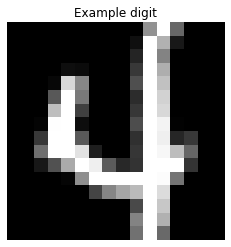

In [8]:
def show_number(nr,data):    
    X=np.array(data)
    X=np.reshape(X[nr,:],(16,16))
    imgplot = plt.imshow(X,cmap='gray')
    plt.axis('off')
    
    plt.title('Example digit')
    plt.show()
show_number(np.random.randint(0,10),X_train)


How big is the difference between numbers?

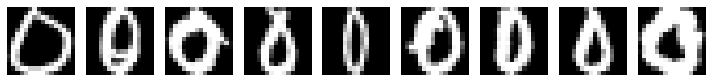

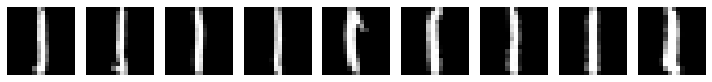

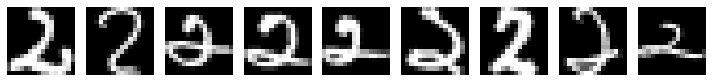

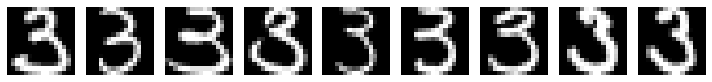

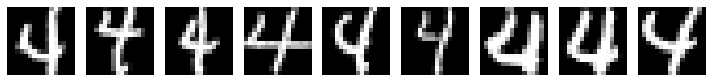

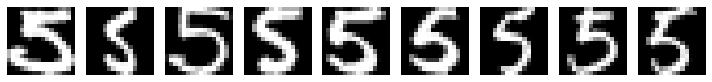

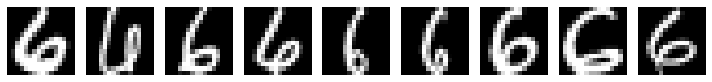

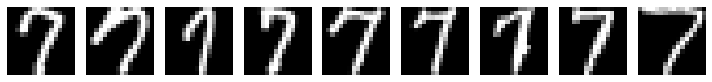

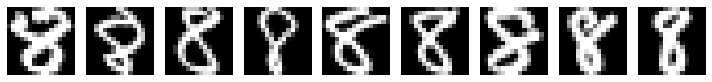

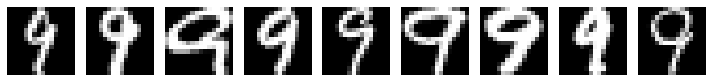

In [15]:
def get_image(nr,data):
    if 'label' in data.columns:
        data=np.array(data.drop('label',axis=1))
    else:
        data=data.values
    return np.reshape(data[nr,:],(16,16))

def display_multiple_img(images, rows = 3, cols=3):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(10,10))
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title],cmap='gray')
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

def display_digits(digit,data,rows,cols):
    total_images = rows*cols
    index=data.loc[data.label==digit].index[:total_images]
    images = {'Image'+str(i):get_image(i,data) for i in index}
    display_multiple_img(images, rows, cols)

    
for i in range(10):
    display_digits(i,df_train,rows=1,cols=9)

#### part 1
For each digit d in range(10) calculate the 'centre': $c_{d}$ as the mean of allcoordinates of vectors constructin $C_{d}$.
Once we have these centers, we can easily classify new images.

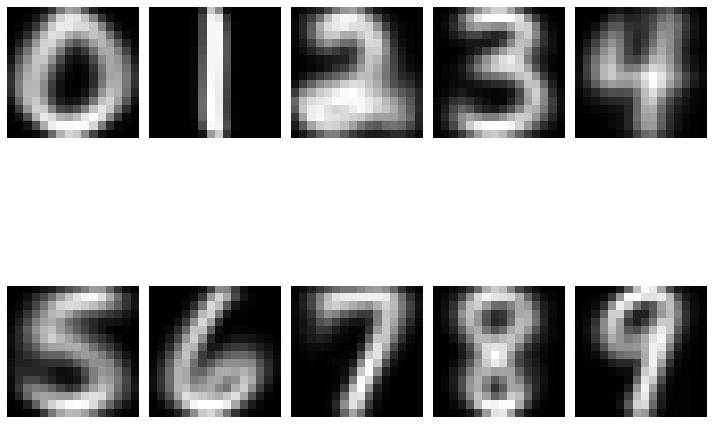

In [14]:
c_ds=df_train.groupby('label').mean()

images = {'Image'+str(i):get_image(i,c_ds) for i in range(10)}
display_multiple_img(images, 2,5)

Next, calculate the distances between the centers of the 10 clouds, $dist_{ij} = dist(c_{i}; c_{j} )$, for
$i,j = 0,1,...9$.

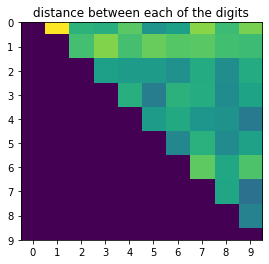

In [13]:
from itertools import product
dist_ij=np.zeros((10,10))
for i,j in product(range(10),range(10)):
    if j>=i:
        dist_ij[i,j]=np.linalg.norm(c_ds.iloc[i].values-c_ds.iloc[j].values)
imgplot = plt.imshow(dist_ij)
plt.title(label='distance between each of the digits')
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

#### Question
Given all these distances, try to say something about the expected accuracy of your
classifier. What pairs of digits seem to be most difficult to separate?
#### Answer
Looking at the graph i would suspect its hard to distinguish between 4 and 9, 7 and 9, 8 and 9, 3 and 5.  

#### Part 2: expirement with dimensionality reduction: PCA, LLE and t-SNE

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from matplotlib import cm

In [20]:
#Dimension reduction
pca = PCA(n_components=2)
lle = LocallyLinearEmbedding(n_components=2)
tsne = TSNE(n_components=2)

methods={'pca':pca,'lle':lle,'tsne':tsne}
dfs=dict()
for key in methods:
    X=methods[key].fit_transform(X_train)
    df=pd.DataFrame(X)
    df['label']=Y_train
    dfs[key]=df

In [21]:
def scatter_plot(c_ds,title):
    fig, ax = plt.subplots()
    colors={0:'tab:red',1:'tab:blue',2:'tab:orange',3:'tab:green',4:'tab:purple',5:'tab:brown',6:'tab:pink',7:'tab:gray',8:'tab:olive',9:'tab:cyan'}
    for key in colors:
        x=c_ds.loc[c_ds.label==key].values[:,0]
        y=c_ds.loc[c_ds.label==key].values[:,1]
        ax.scatter(x,y, c=colors[key], label=key,
                   alpha=0.3, edgecolors='none')
    
    
    average=c_ds.groupby('label').mean()
    ax.scatter(average.values[:,0],average.values[:,1])
    for i in range(10):
        label = f"{c_ds.index[i]}"
        plt.annotate(label, # this is the text
             (average.values[i,0],average.values[i,1]), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,10), # distance from text to points (x,y)
             ha='center') # horizontal alignment can be left, right or   
    ax.legend()
    plt.title(title)
    plt.show()

Distributions after dimension reduction:

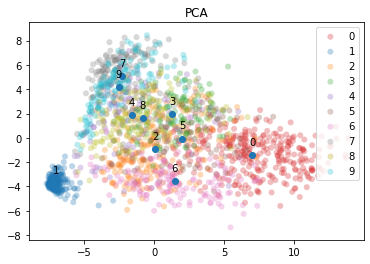

In [22]:
scatter_plot(dfs['pca'],'PCA')

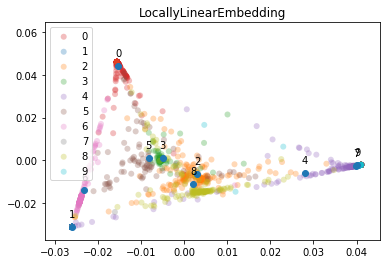

In [23]:
scatter_plot(dfs['lle'],'LocallyLinearEmbedding')

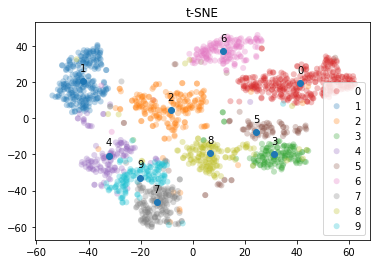

In [24]:
scatter_plot(dfs['tsne'],'t-SNE')

#### Task 3: implement the simplest distance-based classifier

In [163]:
class DistanceBasedClassifier:

    def __init__(self):
        self.c_ds=None
        
    def fit(self,X,Y):
        df_train = X.copy()
        df_train['label']=Y
        self.c_ds=df_train.groupby('label').mean()
    
    def predict(self,X):
        probability_matrix=pd.DataFrame()
        for i in range(10):
            df=X-self.c_ds.iloc[i]
            probability_matrix[i]=np.sqrt(np.multiply(df.abs(),df.abs()).sum(axis=1))
        predictions=np.argmin(probability_matrix.values,axis=1)
        #self.probabilities=1-(np.min(dbc.probability_matrix,axis=1)/np.sum(dbc.probability_matrix,axis=1))
        return predictions
    
    def score(self,X,Y):
        predictions=self.predict(X)
        acc=(np.sum(predictions==Y.values.T))/len(Y)
        return acc

In [164]:
dbc=DistanceBasedClassifier()
dbc.fit(X_train,Y_train)

In [165]:
prediction=dbc.predict(X_train)

Percentage correctly classified in trainset:

In [166]:
dbc.score(X_train,Y_train)

0.8635032220269478

In [167]:
X_test = pd.read_csv('./data/test_in.csv',header=None)
Y_test = pd.read_csv('./data/test_out.csv',header=None)

In [168]:
Y_pred_dbc=dbc.predict(X_test)

Percentage correctly classified in testset:

In [169]:
dbc.score(X_test,Y_test)

0.804

In [170]:
print(classification_report(Y_test, Y_pred_dbc))

              precision    recall  f1-score   support

           0       0.90      0.79      0.85       224
           1       0.91      0.99      0.95       121
           2       0.85      0.68      0.76       101
           3       0.75      0.77      0.76        79
           4       0.67      0.80      0.73        86
           5       0.72      0.69      0.70        55
           6       0.75      0.87      0.80        90
           7       0.85      0.78      0.81        64
           8       0.74      0.79      0.76        92
           9       0.75      0.77      0.76        88

    accuracy                           0.80      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.81      0.80      0.80      1000



#### Part 4: the KNN approach

In [171]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train.values.ravel())

KNeighborsClassifier()

In [172]:
Y_pred_knn=knn.predict(X_test)
knn.score(X_test,Y_test)

0.908

In [173]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred_knn))


              precision    recall  f1-score   support

           0       0.90      0.98      0.94       224
           1       0.91      0.98      0.94       121
           2       0.93      0.83      0.88       101
           3       0.82      0.89      0.85        79
           4       0.94      0.92      0.93        86
           5       0.95      0.64      0.76        55
           6       0.94      0.94      0.94        90
           7       0.86      0.88      0.87        64
           8       0.95      0.86      0.90        92
           9       0.88      0.93      0.91        88

    accuracy                           0.91      1000
   macro avg       0.91      0.88      0.89      1000
weighted avg       0.91      0.91      0.91      1000



Confusion matrices

In [174]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix_knn=confusion_matrix(Y_test,Y_pred_knn)#confusion matrix knn
conf_matrix_dbc=confusion_matrix(Y_test,Y_pred_dbc)#confusion matrix distance based classifier

#def plot_conf_matrix(conf_matrix,title):
#    fig, ax = plt.subplots(figsize=(11,11))
#    ax.matshow(conf_matrix, aspect='auto')
#    ax.set(title=title, xticks=range(10), 
#           yticks=range(10))
#    for (i, j), val in np.ndenumerate(conf_matrix):
#        ax.annotate('{:0.2f}'.format(val), (j,i), ha='center', va='center',color='white')


In [175]:
#plot_conf_matrix(conf_matrix_knn,'Confusion Matrix for knn')

In [176]:
#plot_conf_matrix(conf_matrix_dbc,'Confusion Matrix for dbc')

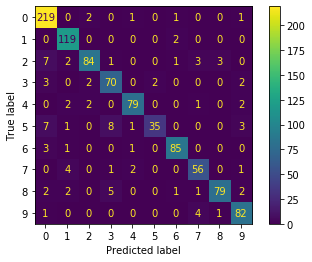

In [177]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn)
disp = disp.plot()
plt.show()

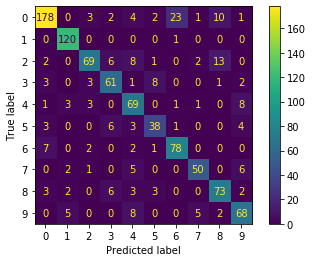

In [178]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dbc)
disp = disp.plot()
plt.show()

### Task 2: Implement a multi-class perceptron algorithm

In [87]:
X_train = pd.read_csv('./data/train_in.csv',header=None)
Y_train = pd.read_csv('./data/train_out.csv',header=None)
X_test = pd.read_csv('./data/test_in.csv',header=None)
Y_test = pd.read_csv('./data/test_out.csv',header=None)
df_train = X_train.copy()
df_train['label']=Y_train
T_train=X_train.copy()
T_train['bias']=1
T_test=X_test.copy()
T_test['bias']=1

Perceptron in pseudo code:
initialize weights at random. <br>
while there are misclassified examples: <br>
  for  misclassified examples:<br>
    if W_prediction > W_label: W_pred = W_pred-X<br>
    and W_label=W_label + X<br>


In [158]:
class MultiClassPerceptron:
    def __init__(self):
        self.weigths=None
    
    def fit(self,X,Y):
        W_x=X.shape[1]
        W_y=Y.shape[0]
        total=len(Y_train)
        W,counter,times_right,score=self.initialize((W_x,W_y))        
        
        while ((score<0.90) | (counter<30)):
            prediction=np.argmax(np.dot(X,W),axis=1)
            for i,(pred,label) in enumerate(zip(prediction,Y.values[:,0])):
                if pred != label:
                    W[:,pred]-=T_train.iloc[i]*(W[:,pred]>W[:,label])
                    W[:,label]+=T_train.iloc[i]*(W[:,pred]>W[:,label])
            times_right=sum(prediction.T==Y.values[:,0])
            score=times_right/total    
            counter+=1
        print(f'itaration {counter}, times right: {times_right},percentage: {score}')
        self.weigths=W
        
    def predict(self,X):
        W=self.weigths
        prediction=np.argmax(np.dot(X,W),axis=1)
        return prediction
    
    def initialize(self,shape):
        W=np.random.random(shape)
        (counter,times_right,score)=(0,0,0)
        return (W,counter,times_right,score)
    
    def score(self,X,Y):
        predictions=self.predict(X)
        acc=(np.sum(predictions==Y.values.T))/len(Y)
        return acc


In [159]:
mcp=MultiClassPerceptron()
mcp.fit(T_train,Y_train)

itaration 30, times right: 1585,percentage: 0.9285295840656121


In [160]:
Y_pred_mcp=mcp.predict(T_test)

In [161]:
print(classification_report(Y_test, Y_pred_mcp))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       224
           1       0.96      0.94      0.95       121
           2       0.77      0.77      0.77       101
           3       0.84      0.75      0.79        79
           4       0.81      0.77      0.79        86
           5       0.69      0.65      0.67        55
           6       0.95      0.82      0.88        90
           7       0.75      0.84      0.79        64
           8       0.76      0.78      0.77        92
           9       0.84      0.85      0.85        88

    accuracy                           0.84      1000
   macro avg       0.82      0.81      0.82      1000
weighted avg       0.84      0.84      0.84      1000



In [162]:
mcp.score(T_test,Y_test)

0.839

### Task 3

In [220]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def xor_net(x1, x2,weights):
    '''
    input 2-d
    hidden layer1 2 nodes
    hidden layer2 1 node, activation: sigmoid
    '''
    W1=np.reshape(weights[:4],(2,2))
    b1=weights[4:6]
    W2=np.reshape(weights[6:8],(2,1))
    b2=weights[-1]
    
    #input layer
    X0=np.array([x1,x2]).T
    # hidden layer1
    Y1=sigmoid(np.dot(X0,W1)+b1)
    #hidden layer2
    Y=sigmoid(np.dot(Y1,W2)+b2)
    return Y,Y1

In [189]:
weights=np.random.random(9)
x1=2
x2=3
xor_net(x1,x2,weights)

array([0.92051429])

In [188]:
def xor_net_2(x1, x2,weights):
    (w13,w14,w23,w24,bias3,bias4,w3y,w4y,biasy)=weights 
    Y=sigmoid(biasy+w3y*sigmoid(bias3+w13*x1+w23*x2)+w4y*sigmoid(bias4+w14*x1+w24*x2))
    return Y

weights = (biasy,bias3,bias4,w13,w14,w23,w24,w3y,w4y)

In [190]:
xor_net_2(x1, x2,weights)

0.9205142928045383

In [191]:
#define data with corresponding targets
x = {'x1':[0,0,1,1],'x2':[0,1,0,1]}
xdf = pd.DataFrame(data=x)
y = {'target':[0,1,1,0]}
ydf = pd.DataFrame(data=y)
df=xdf.copy()
df['target']=y['target']

In [193]:
def mse(weights_initial,X_data,Y_data):
    sumerror=0
    for i in range(len(x['x1'])):
        errorsq = np.square(xor_net(X_data.iloc[i][0],X_data.iloc[i][1],weights_initial)
        -Y_data.iloc[i][0])
        sumerror+=errorsq
    mserror=sumerror/len(X_data['x1'])
    return mserror

def mse2(output,labels,W):
    mserror=np.square(output-labels).mean()
    return mserror,W

In [237]:
def grdmse(weights_initial,X_data,Y_data,delta):
    gradient=np.zeros(9)
    weights_delta=weights_initial.copy()
    for i in range(len(weights_initial)):
        weights_delta[i]+=delta
        gradient_i=(mse(weights_delta,X_data,Y_data)-mse(weights_initial,X_data,Y_data))/delta
        #op een of andere manier is weights_delta==weights_initial true hier?
        #hierdoor gradient_i=0
        weights_delta[i]-=delta
        gradient[i]+=gradient_i
    return gradient

def grdmse2(weights,X,Y1,Y,error):
    W1=np.reshape(weights[:4],(2,2))
    b1=weights[4:6]
    W2=np.reshape(weights[6:8],(2,1))
    b2=weights[-1]
    
    dW2=Y*(1-Y)*error*Y1
    db2=Y*(1-Y)*error
    dW1=Y1*(1-Y1)*error*X
    db1=Y1*(1-Y1)*error
    d_weights=np.hstack([W1.ravel(),b1.ravel(),W2.ravel(),b2.ravel()])
    return d_weights

In [197]:
grdmse(weights,xdf,ydf,0.1)

array([0.00359822, 0.00392592, 0.0032538 , 0.00388761, 0.01336757,
       0.01075546, 0.05481364, 0.05131282, 0.07497849])

In [238]:
x1=np.array([0,0,1,1])
x2=np.array([0,1,0,1])
X=np.array([x1,x2]).T
y=np.array([0,1,1,0])
weights=np.random.random(9)



In [262]:
output,Y1=xor_net(x1, x2,weights)        
error,W=mse2(output,Y1,weights)
d_weights=grdmse2(weights,X,Y1,output,error)
weights=weights-0.1*d_weights
error

0.00045464019842001384